Урок 5. Рекуррентные нейронные сети
---

**Домашнее задание**:
Используя файл Web5.ipynb (он в полезных ссылках):

Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

**Описание датафрейма**

Датафейм представляет собой показатели работы скважин (дебит нефти, воды, газа, обводнённость и т.д.). Каждый парметр задан на 1-е число каждого месяца.
Особенность датафрейма в том, что в нём описаны параметры работы нескольких скважин и даты по разным скважинам пересекатся. Т.е. количество временных рядов равно количеству скважин и даты в датасете повторяются.
Есть ли какое-то нюансы в работе с датафреймами, где множество временных рядов и которые нужно учитывать?

В первой части ноутбука для LSTM и GRU датафрейм разбивается на трейн и тест по строке № 3962 (это граница между двумя скважинами). Граница выбрана так, чтобы никакая скважина не оказалась в трейне и тесте, а только или там или там. Скважины до этой строки идут в трейн (со всем периодом работы), после - в тест. Разбивка примерно 70/30**.

Во второй части датафрейм разбивается на трейн/тест по времени по каждой скважине.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D
from tensorflow.keras.models import Sequential, Model
from keras.layers import LSTM
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GRU,
                                     Input, Concatenate, Average, Maximum, Add, Subtract, Multiply,
                                    GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D)

In [2]:
# fix random seed for reproducibility
np.random.seed(7)

In [3]:
data_path = '../../data/prod_data/prod_data_wo_nan.xlsx'
df_orig = pd.read_excel(data_path, sheet_name='prod')

In [4]:
df = df_orig.copy()
df.head(3)

,Date,Day,Well,Formation,Lift type,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3",WCT,"Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours
0,1996-05-01,35186,Plat-2,Evlanov-Livenskian,Natural flow,1549.516908,1283,0.0,0.0,173.20,0.0,0.828,1.164,336.0,408.0
1,1996-06-01,35217,Plat-2,Evlanov-Livenskian,Natural flow,4330.917874,3586,0.0,0.0,484.11,0.0,0.828,1.164,696.0,24.0
2,1996-07-01,35247,Plat-2,Evlanov-Livenskian,Natural flow,5179.951691,4289,0.0,0.0,630.50,0.0,0.828,1.164,744.0,0.0


In [5]:
# замена имён скважин на номера
df.replace({'Plat-2': 2, 'Plat-3': 3, 'Plat-5': 5, 'Plat-6': 6, 'Plat-8': 8, 'Plat-9': 9, 'Plat-10': 10,
            'Plat-11': 11, 'Plat-12': 12, 'Plat-13': 13, 'Plat-15': 15, 'Plat-17': 17, 'Plat-19': 19,
            'Plat-20': 20, 'Plat-26': 26, 'Plat-27': 27, 'Plat-29': 29, 'Plat-44': 44, 'Plat-55': 55,
            'Plat-61': 61, 'Plat-66': 66, 'Plat-70': 70, 'Plat-71': 71, 'Plat-72': 72, 'Plat-81': 81,
            'Avil-6': 106, 'Avil-7': 107, 'Avil-8': 108, 'Avil-10': 210, 'Avil-15': 215, 'Avil-11': 211,
            'Avil-12': 212, 'Avil-32': 32, 'Avil-33': 33, 'Avil-111': 111, 'Avil-112': 112,
            'Avil-113': 113, 'Avil-114': 114, 'Avil-117': 117,
           }, inplace=True)

In [6]:
df.head(3)

,Date,Day,Well,Formation,Lift type,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3",WCT,"Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours
0,1996-05-01,35186,2,Evlanov-Livenskian,Natural flow,1549.516908,1283,0.0,0.0,173.20,0.0,0.828,1.164,336.0,408.0
1,1996-06-01,35217,2,Evlanov-Livenskian,Natural flow,4330.917874,3586,0.0,0.0,484.11,0.0,0.828,1.164,696.0,24.0
2,1996-07-01,35247,2,Evlanov-Livenskian,Natural flow,5179.951691,4289,0.0,0.0,630.50,0.0,0.828,1.164,744.0,0.0


In [7]:
df.shape

(5665, 15)

In [8]:
def well_plot(well_name, df, pred=None, pred_val=None):
    """
    Построение графика скважины

    Parameters
    ----------
    well_name:
        Имя скважины

    metric: callable
        Функция для оценки качества прогнозов, функция принимает
        2 аргумента: вектор истинных ответов и вектор прогнозов.

    df: pandas.core.frame.DataFrame
        Датафрейм с параметрами работы скважин

    pred: numpy.ndarray
        Массив предсказанных значений обводнённости

    """

    # Data
    x = df['Date'].where(df['Well'] == well_name)
    y = df['Oil production (actual), t'].where(df['Well'] == well_name).to_numpy(), \
        df['Water production, t'].where(df['Well'] == well_name).to_numpy()
    wct = df['WCT'].where(df['Well'] == well_name).to_numpy()

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Oil & water production', color='black')
    #ax1.plot(x, y, color=color)
    colors = ['#C9C19C', '#A9DDFF']
    ax1.stackplot(x, y, labels=['Oil production (actual), t', 'Water production, t'], colors=colors)
    ax1.tick_params(axis='y', labelcolor='black')
    #plt.legend(loc='upper left')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = '#13CAE9'
    ax2.set_ylabel('WCT, %', color=color)  # we already handled the x-label with ax1
    ax2.plot(x, wct, color=color, linestyle='dashed', linewidth=2,  label='WCT true, %')
    
    if isinstance(pred, np.ndarray): # без этих 2-х проверок ошибки
        if pred.any():
            if isinstance(pred_val, np.ndarray):
                color = 'red'
                ax2.plot(x[len(pred)+x_len+bias+future+12:],
                         pred_val, color=color, linestyle='dashed', linewidth=2,  label='WCT predicted (test), %')
                ax2.tick_params(axis='y', labelcolor=color)
            else:
                color = 'red'
                ax2.plot(x[:len(pred)], pred, color=color, linestyle='dashed', linewidth=2,  label='WCT pred train, %')
                ax2.tick_params(axis='y', labelcolor=color)

    # legend
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, loc='upper left')
    plt.legend(loc='upper left', bbox_to_anchor=(0.16,1))
    
    plt.title('Скважина № ' + str(well_name))
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.rcParams["figure.figsize"] = (16,6)
    
    return plt.show()

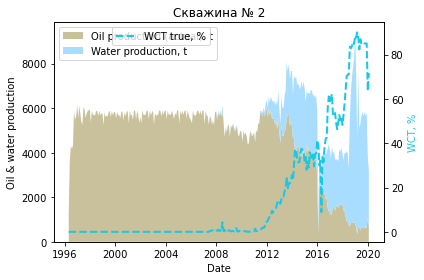

In [9]:
well_plot(2, df)

In [10]:
df.columns

Index(['Date', 'Day', 'Well', 'Formation', 'Lift type', 'Oil production, m3',
       'Oil production (actual), t', 'Water production, m3',
       'Water production, t', 'Gas production, M m3', 'WCT',
       'Oil density, t/m3', 'Water density, t/m3', 'Working hours',
       'Downtime hours'],
      dtype='object')

In [11]:
# список признаков, по которым будем учить
features = ['Date', 'Day', 'Well', 'Choke, mm', 'THP, MPa',
       'Oil production, m3', 'Oil production (actual), t',
       'Water production, m3', 'Water production, t', 'Gas production, M m3',
       'Working hours', 'Downtime hours']

target = 'WCT'

In [12]:
df['liquid, m3'] = df['Oil production, m3'] + df['Water production, m3']
df.head(3)

,Date,Day,Well,Formation,Lift type,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3",WCT,"Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours,"liquid, m3"
0,1996-05-01,35186,2,Evlanov-Livenskian,Natural flow,1549.516908,1283,0.0,0.0,173.20,0.0,0.828,1.164,336.0,408.0,1549.516908
1,1996-06-01,35217,2,Evlanov-Livenskian,Natural flow,4330.917874,3586,0.0,0.0,484.11,0.0,0.828,1.164,696.0,24.0,4330.917874
2,1996-07-01,35247,2,Evlanov-Livenskian,Natural flow,5179.951691,4289,0.0,0.0,630.50,0.0,0.828,1.164,744.0,0.0,5179.951691


In [13]:
data = df

In [14]:
features, target

(['Date',
  'Day',
  'Well',
  'Choke, mm',
  'THP, MPa',
  'Oil production, m3',
  'Oil production (actual), t',
  'Water production, m3',
  'Water production, t',
  'Gas production, M m3',
  'Working hours',
  'Downtime hours'],
 'WCT')

In [15]:
data.columns

Index(['Date', 'Day', 'Well', 'Formation', 'Lift type', 'Oil production, m3',
       'Oil production (actual), t', 'Water production, m3',
       'Water production, t', 'Gas production, M m3', 'WCT',
       'Oil density, t/m3', 'Water density, t/m3', 'Working hours',
       'Downtime hours', 'liquid, m3'],
      dtype='object')

In [16]:
data.drop(['Date', 'Formation', 'Lift type'], axis=1, inplace=True)

In [17]:
data.head(3)

,Day,Well,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3",WCT,"Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours,"liquid, m3"
0,35186,2,1549.516908,1283,0.0,0.0,173.20,0.0,0.828,1.164,336.0,408.0,1549.516908
1,35217,2,4330.917874,3586,0.0,0.0,484.11,0.0,0.828,1.164,696.0,24.0,4330.917874
2,35247,2,5179.951691,4289,0.0,0.0,630.50,0.0,0.828,1.164,744.0,0.0,5179.951691


In [18]:
# список признаков, по которым будем учить
features = ['Day', 'Well', 'Oil production, m3', 'Oil production (actual), t',
       'Water production, m3', 'Water production, t', 'Gas production, M m3',
       'Working hours', 'Downtime hours']


In [19]:
# Разбиваем выборку на обучение и на тест.

train_size = 3962 # граница между 55 и 61 скважиной
# отступ теста от тренировки
bias = 1


# делим выборку на трейн и тест
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((3962, 9), (1702, 9))

Формируем параметры для генерации выборки

In [20]:
# длина истории
x_len = 7

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 64
epochs = 100

In [21]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head(3)

,Day,Well,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3",Working hours,Downtime hours
0,-2.142890,-1.089624,-0.509976,-0.508651,-0.478705,-0.478703,-0.638435,-1.559176,3.837693
1,-2.129636,-1.089624,0.537488,0.535786,-0.478705,-0.478703,0.163180,0.202513,-0.010736
2,-2.116809,-1.089624,0.857230,0.854605,-0.478705,-0.478703,0.540615,0.437405,-0.251262


In [22]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values # преобразовываем датафрейм в список списков
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

X_train.shape, y_train.shape, X_val.shape, y_val.shape

8 3970
1694 3971


((3962, 9), (3962,), (1694, 9), (1694,))

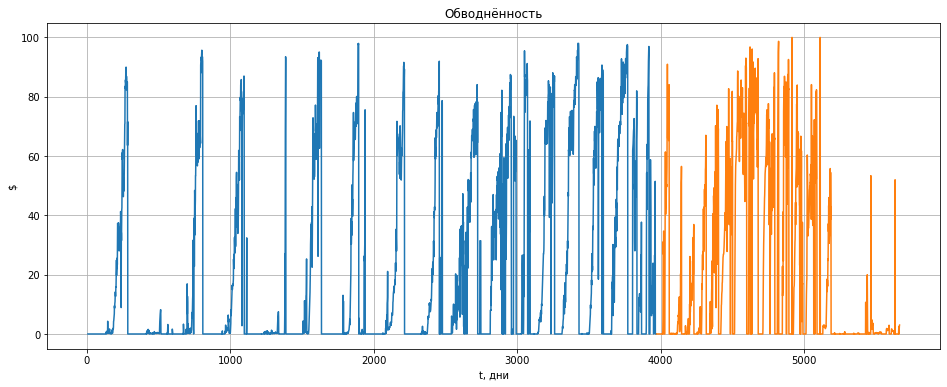

In [23]:
plt.figure(figsize=(16, 6))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
plt.title('Обводнённость')
plt.show()

In [24]:
y_train.shape[0]

3962

# LSTM

In [25]:
from keras.preprocessing import timeseries_dataset_from_array # препроцессинг keras для временных рядов

# Returns a tf.data.Dataset instance. If targets was passed, the dataset yields tuple 
# (batch_of_sequences, batch_of_targets). If not, the dataset yields only batch_of_sequences.
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [29]:
print(len(dataset_train))
dataset_train

62


<BatchDataset shapes: ((None, None, 9), (None,)), types: (tf.float64, tf.float64)>

In [30]:
dataset_train.take(1)

<TakeDataset shapes: ((None, None, 9), (None,)), types: (tf.float64, tf.float64)>

In [26]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (64, 7, 9)
tf.Tensor(
[[-2.12963566 -1.08962415  0.53748758  0.53578645 -0.47870485 -0.47870259
   0.16317992  0.2025132  -0.01073568]
 [-2.11680864 -1.08962415  0.85723009  0.85460506 -0.47870485 -0.47870259
   0.54061513  0.43740512 -0.25126248]
 [-2.10355406 -1.08962415  0.81083786  0.80834688 -0.47870485 -0.47870259
   0.5006517   0.43740512 -0.25126248]
 [-2.09029948 -1.08962415  0.86814591  0.86548934 -0.47870485 -0.47870259
   0.57800027  0.31995916 -0.25126248]
 [-2.07747247 -1.08962415  1.58040305  1.57568841 -0.47870485 -0.47870259
   1.23417392  0.43740512 -0.25126248]
 [-2.06421789 -1.08962415  1.39756309  1.39337677 -0.47870485 -0.47870259
   1.11789325  0.31995916 -0.25126248]
 [-2.05139087 -1.08962415  1.46669661  1.46231052 -0.47870485 -0.47870259
   1.05704571  0.43740512 -0.25126248]], shape=(7, 9), dtype=float64)
Target shape: (64,)
tf.Tensor(0.0, shape=(), dtype=float64)


In [27]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)


model = Sequential()

model.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Conv1D(64, 3, activation='linear'))
model.add(Conv1D(64, 1, activation='linear'))
model.add(Flatten())
model.add(Dense(3, activation='linear'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 32)             5376      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 32)             8320      
_________________________________________________________________
conv1d (Conv1D)              (None, 5, 64)             6208      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             4160      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 963       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4

In [28]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop]
                   )

Epoch 1/100
62/62 [==============================] - 5s 33ms/step - loss: 691.6054 - mae: 11.7269 - val_loss: 1012.0624 - val_mae: 24.3713
Epoch 2/100
62/62 [==============================] - 1s 9ms/step - loss: 337.3350 - mae: 12.5116 - val_loss: 678.2565 - val_mae: 19.1780
Epoch 3/100
62/62 [==============================] - 1s 9ms/step - loss: 192.3883 - mae: 7.7213 - val_loss: 695.1247 - val_mae: 18.8225
Epoch 4/100
62/62 [==============================] - 1s 10ms/step - loss: 189.6365 - mae: 7.2490 - val_loss: 618.1957 - val_mae: 18.1047
Epoch 5/100
62/62 [==============================] - 1s 9ms/step - loss: 165.6120 - mae: 6.3851 - val_loss: 602.1688 - val_mae: 17.8492
Epoch 6/100
62/62 [==============================] - 1s 9ms/step - loss: 154.5990 - mae: 6.0326 - val_loss: 602.6210 - val_mae: 18.2700
Epoch 7/100
62/62 [==============================] - 1s 9ms/step - loss: 144.3565 - mae: 5.7113 - val_loss: 631.3458 - val_mae: 18.9960
Epoch 8/100
62/62 [========================

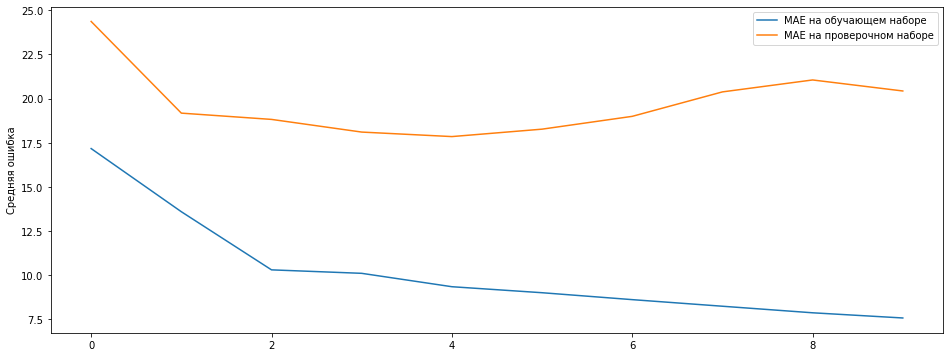

In [29]:
plt.plot(history.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [30]:
pred = model.predict(dataset_train).flatten()
pred_val = model.predict(dataset_val).flatten()

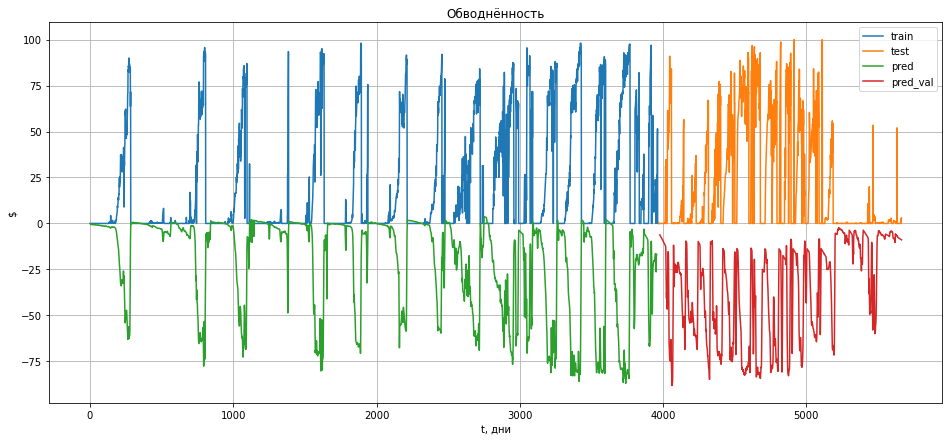

In [31]:
plt.figure(figsize=(16, 7))
plt.plot(data.index[x_len:y_train.shape[0]+x_len], y_train[:], label='train')
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:], y_val[:], label='test')
# умножим на -1 - отобразим предсказания зеркально, чтобы не загромождать
plt.plot(pred[:]* (-1), label='pred')
plt.plot(data.index[y_train.shape[0]+x_len+bias+future+6:], pred_val[:] * (-1), label='pred_val')
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
plt.title('Обводнённость')
plt.legend()
plt.show()

In [32]:
data_path = '../../data/prod_data/prod_data_wo_nan.xlsx'
df = pd.read_excel(data_path, sheet_name='prod')
# замена имён скважин на номера
df.replace({'Plat-2': 2, 'Plat-3': 3, 'Plat-5': 5, 'Plat-6': 6, 'Plat-8': 8, 'Plat-9': 9, 'Plat-10': 10,
            'Plat-11': 11, 'Plat-12': 12, 'Plat-13': 13, 'Plat-15': 15, 'Plat-17': 17, 'Plat-19': 19,
            'Plat-20': 20, 'Plat-26': 26, 'Plat-27': 27, 'Plat-29': 29, 'Plat-44': 44, 'Plat-55': 55,
            'Plat-61': 61, 'Plat-66': 66, 'Plat-70': 70, 'Plat-71': 71, 'Plat-72': 72, 'Plat-81': 81,
            'Avil-6': 106, 'Avil-7': 107, 'Avil-8': 108, 'Avil-10': 210, 'Avil-15': 215, 'Avil-11': 211,
            'Avil-12': 212, 'Avil-32': 32, 'Avil-33': 33, 'Avil-111': 111, 'Avil-112': 112,
            'Avil-113': 113, 'Avil-114': 114, 'Avil-117': 117,
           }, inplace=True)

In [33]:
len(pred)

3956

**Сравним предсказанные и фактические значения на трейне**

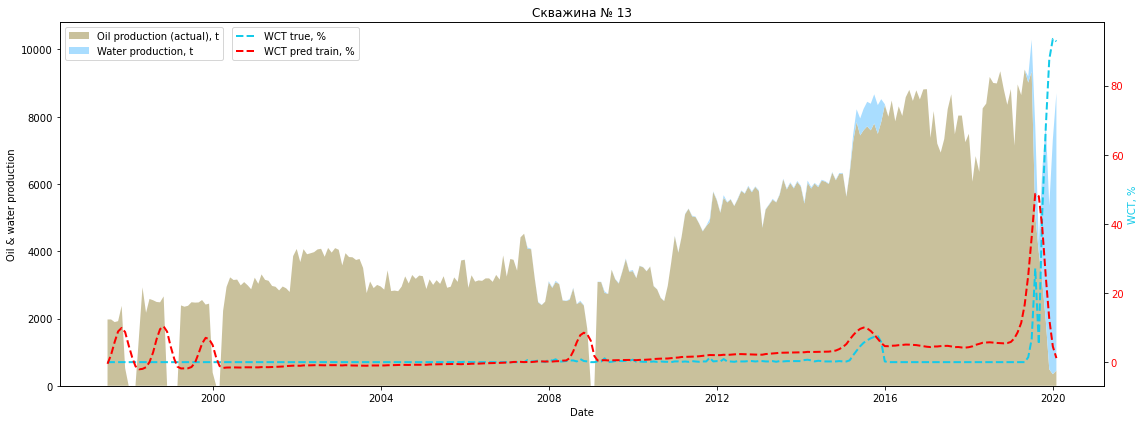

In [34]:
well_plot(13, df, pred)

**Сравним предсказанные и фактические значения на тесте**

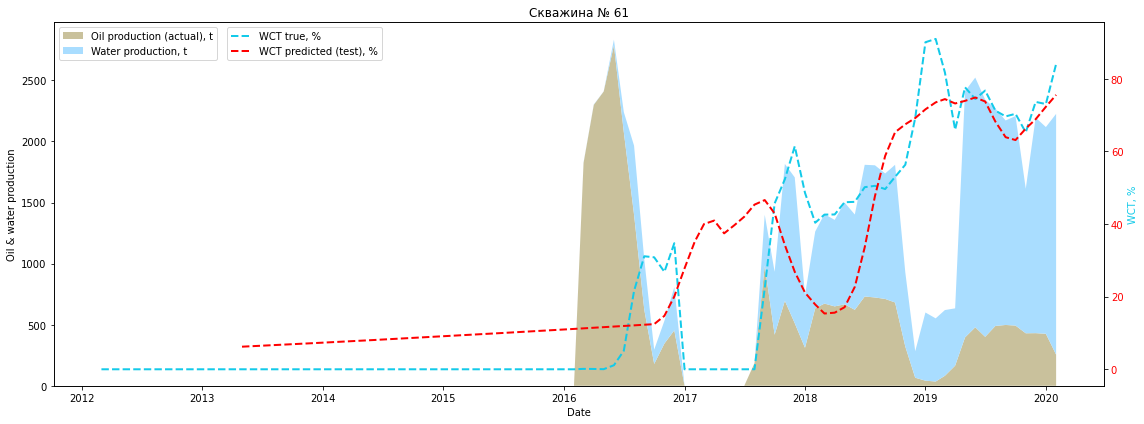

In [35]:
well_plot(61, df, pred, pred_val)

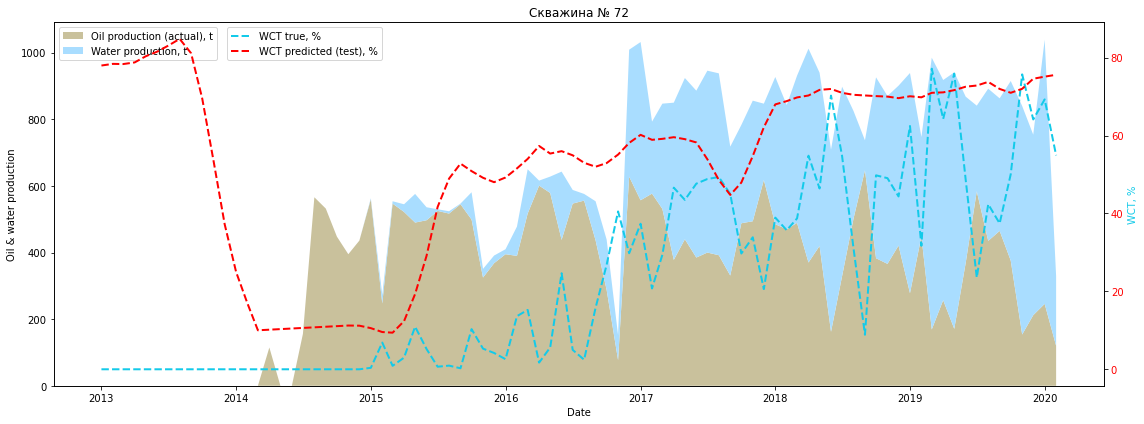

In [36]:
well_plot(72, df, pred, pred_val)

**Сравним визуально реальную и предсказанную обводнённость**

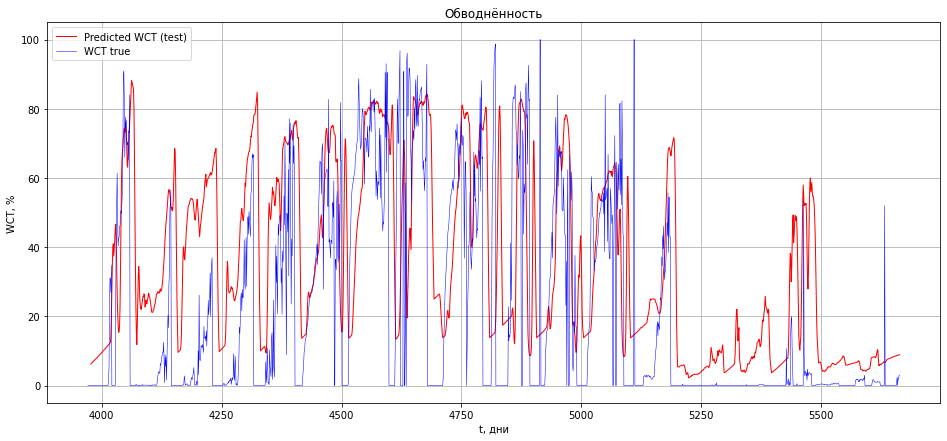

In [37]:
plt.figure(figsize=(16, 7))
plt.plot(data.index[y_train.shape[0]+x_len+bias+future + 6:], pred_val[:], 
         label='Predicted WCT (test)', color='red', linewidth=1)
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:], y_val[:], 
         label='WCT true', color='blue', linewidth=0.5)
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('WCT, %')
plt.title('Обводнённость')
plt.legend(loc='upper left')
plt.show()

# GRU

In [38]:
# установка ряда метапареметров  для нейронной сети и процесса тренировки
batch_size = 64
hidden_size = 32
num_iterations = 25 
num_epochs = 1
num_preds = 100

In [39]:
model_2 = Sequential()
model_2.add(
    GRU(
        hidden_size,
        return_sequences=True,
        input_shape=(inputs.shape[1], inputs.shape[2]),
        unroll=True
    )
)
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7, 32)             4128      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 64)             6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 64)             4160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 963       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 15,463
Trainable params: 15,463
Non-trainable params: 0
__________________________________________________

In [40]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/100
62/62 [==============================] - 2s 11ms/step - loss: 586.5428 - mae: 11.3250 - val_loss: 1518.2418 - val_mae: 32.4760
Epoch 2/100
62/62 [==============================] - 0s 6ms/step - loss: 770.7859 - mae: 20.8638 - val_loss: 790.7021 - val_mae: 20.9879
Epoch 3/100
62/62 [==============================] - 0s 7ms/step - loss: 357.7591 - mae: 12.7136 - val_loss: 576.8102 - val_mae: 19.1804
Epoch 4/100
62/62 [==============================] - 0s 6ms/step - loss: 249.4343 - mae: 10.1488 - val_loss: 571.6331 - val_mae: 19.5624
Epoch 5/100
62/62 [==============================] - 0s 6ms/step - loss: 213.3497 - mae: 9.0113 - val_loss: 561.3531 - val_mae: 19.2737
Epoch 6/100
62/62 [==============================] - 0s 7ms/step - loss: 186.5632 - mae: 8.1302 - val_loss: 536.1076 - val_mae: 18.4321
Epoch 7/100
62/62 [==============================] - 0s 6ms/step - loss: 165.4603 - mae: 7.4081 - val_loss: 508.6479 - val_mae: 17.5012
Epoch 8/100
62/62 [=======================

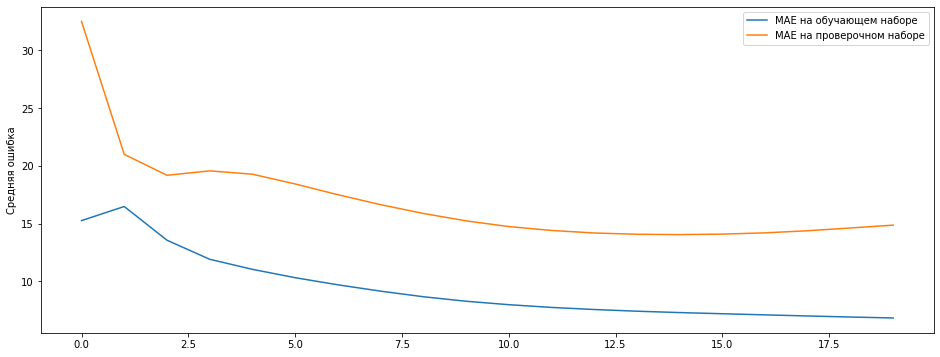

In [41]:
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [42]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

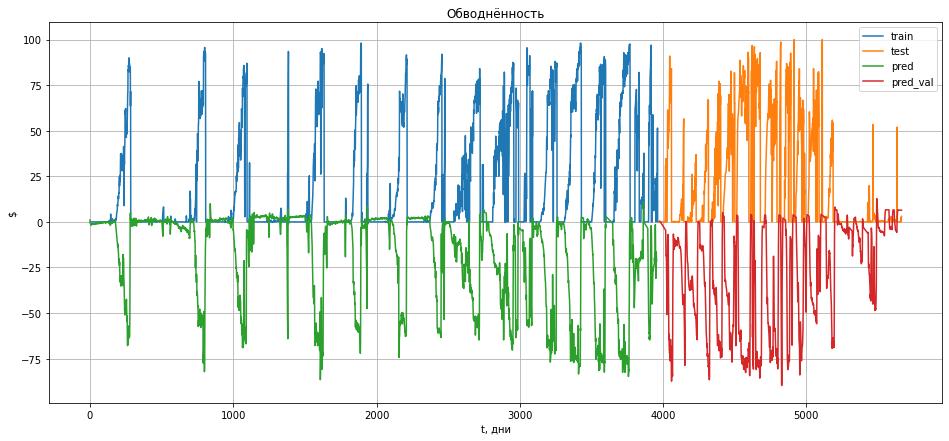

In [43]:
plt.figure(figsize=(16, 7))
plt.plot(data.index[x_len:y_train.shape[0]+x_len], y_train[:], label='train')
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:], y_val[:], label='test')
# умножим на -1 - отобразим предсказания зеркально, чтобы не загромождать
plt.plot(pred_2[:]* (-1), label='pred')
plt.plot(data.index[y_train.shape[0]+x_len+bias+future+6:], pred_val_2[:] * (-1), label='pred_val')
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
plt.title('Обводнённость')
plt.legend()
plt.show()

**Сравним предсказанные и фактические значения на трейне**

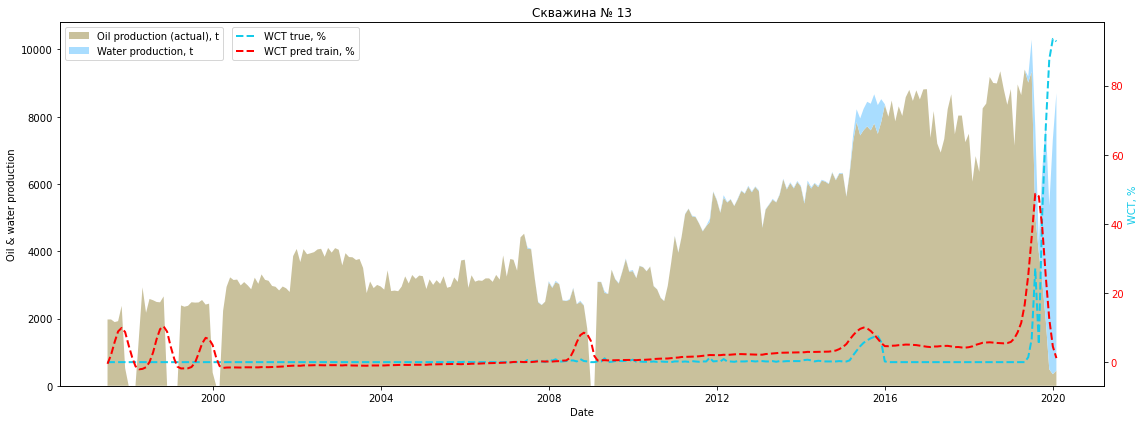

In [44]:
well_plot(13, df, pred)

**Сравним предсказанные и фактические значения на тесте**

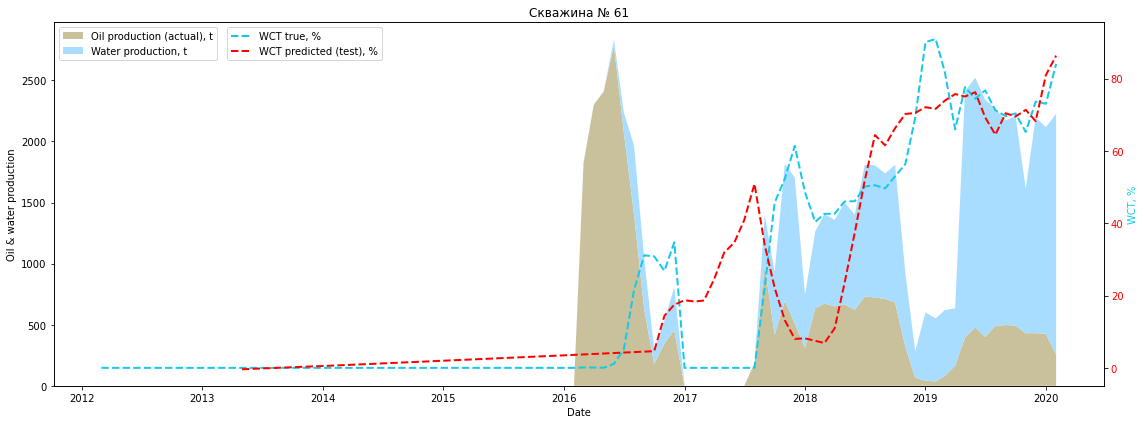

In [45]:
well_plot(61, df, pred, pred_val_2)

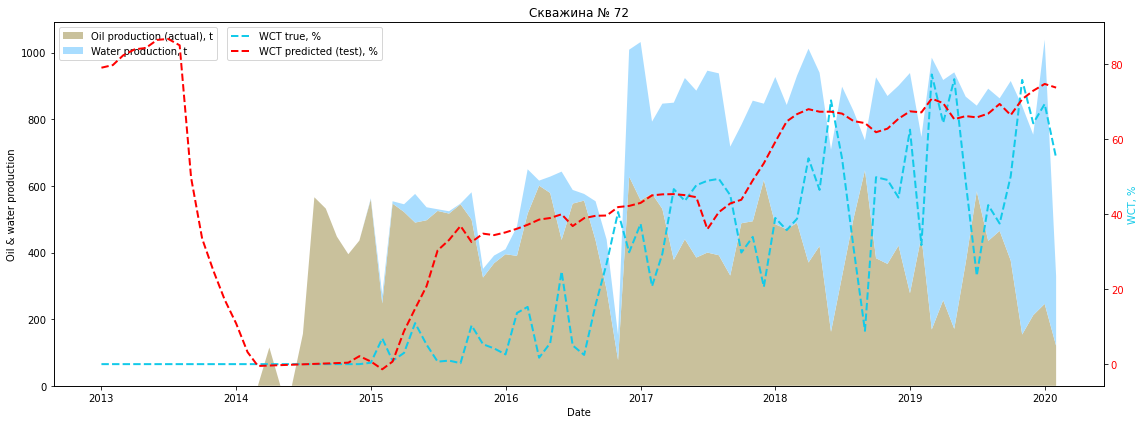

In [46]:
well_plot(72, df, pred_2, pred_val_2)

# Вывод

Качество предсказания удовлетворительное. Модель в целом повторяет тренд роста обводнённости. Рзница между LSTM и GRU незначительная.

Наибольшее влияние оказал размер батча.

Логично попробовать обучать сеть на каждой скважине на начальном этапе времени и строить предсказания на последних датах. Попробуем разбивать выборку трейн/тест по времени по каждой скважине.

# LSTM с разбивкой на трейн/тест по каждой скважине

In [47]:
df = df_orig.copy()
df.head(3)

,Date,Day,Well,Formation,Lift type,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3",WCT,"Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours
0,1996-05-01,35186,Plat-2,Evlanov-Livenskian,Natural flow,1549.516908,1283,0.0,0.0,173.20,0.0,0.828,1.164,336.0,408.0
1,1996-06-01,35217,Plat-2,Evlanov-Livenskian,Natural flow,4330.917874,3586,0.0,0.0,484.11,0.0,0.828,1.164,696.0,24.0
2,1996-07-01,35247,Plat-2,Evlanov-Livenskian,Natural flow,5179.951691,4289,0.0,0.0,630.50,0.0,0.828,1.164,744.0,0.0


In [48]:
# замена имён скважин на номера
df.replace({'Plat-2': 2, 'Plat-3': 3, 'Plat-5': 5, 'Plat-6': 6, 'Plat-8': 8, 'Plat-9': 9, 'Plat-10': 10,
            'Plat-11': 11, 'Plat-12': 12, 'Plat-13': 13, 'Plat-15': 15, 'Plat-17': 17, 'Plat-19': 19,
            'Plat-20': 20, 'Plat-26': 26, 'Plat-27': 27, 'Plat-29': 29, 'Plat-44': 44, 'Plat-55': 55,
            'Plat-61': 61, 'Plat-66': 66, 'Plat-70': 70, 'Plat-71': 71, 'Plat-72': 72, 'Plat-81': 81,
            'Avil-6': 106, 'Avil-7': 107, 'Avil-8': 108, 'Avil-10': 210, 'Avil-15': 215, 'Avil-11': 211,
            'Avil-12': 212, 'Avil-32': 32, 'Avil-33': 33, 'Avil-111': 111, 'Avil-112': 112,
            'Avil-113': 113, 'Avil-114': 114, 'Avil-117': 117,
           }, inplace=True)

In [49]:
# список признаков, по которым будем учить
features = ['Date', 'Day', 'Well', 'Choke, mm', 'THP, MPa',
       'Oil production, m3', 'Oil production (actual), t',
       'Water production, m3', 'Water production, t', 'Gas production, M m3',
       'Working hours', 'Downtime hours', 'Longitude', 'Latitude']

target = 'WCT'

In [50]:
df['liquid, m3'] = df['Oil production, m3'] + df['Water production, m3']
df.head(3)

,Date,Day,Well,Formation,Lift type,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3",WCT,"Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours,"liquid, m3"
0,1996-05-01,35186,2,Evlanov-Livenskian,Natural flow,1549.516908,1283,0.0,0.0,173.20,0.0,0.828,1.164,336.0,408.0,1549.516908
1,1996-06-01,35217,2,Evlanov-Livenskian,Natural flow,4330.917874,3586,0.0,0.0,484.11,0.0,0.828,1.164,696.0,24.0,4330.917874
2,1996-07-01,35247,2,Evlanov-Livenskian,Natural flow,5179.951691,4289,0.0,0.0,630.50,0.0,0.828,1.164,744.0,0.0,5179.951691


In [51]:
# Разбиваем на трейн и тест по дате (по каждой скважине)
df['Date'] = pd.to_datetime(df['Date'])

split_date = pd.datetime(2017,12,31)

train = df.loc[df['Date'] <= split_date]
test = df.loc[df['Date'] > split_date]
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)
train.head(3)

Train Dataset: (4703, 16)
Test Dataset: (962, 16)


<ipython-input-51-066c1ee872f1>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  split_date = pd.datetime(2017,12,31)


,Date,Day,Well,Formation,Lift type,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3",WCT,"Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours,"liquid, m3"
0,1996-05-01,35186,2,Evlanov-Livenskian,Natural flow,1549.516908,1283,0.0,0.0,173.20,0.0,0.828,1.164,336.0,408.0,1549.516908
1,1996-06-01,35217,2,Evlanov-Livenskian,Natural flow,4330.917874,3586,0.0,0.0,484.11,0.0,0.828,1.164,696.0,24.0,4330.917874
2,1996-07-01,35247,2,Evlanov-Livenskian,Natural flow,5179.951691,4289,0.0,0.0,630.50,0.0,0.828,1.164,744.0,0.0,5179.951691


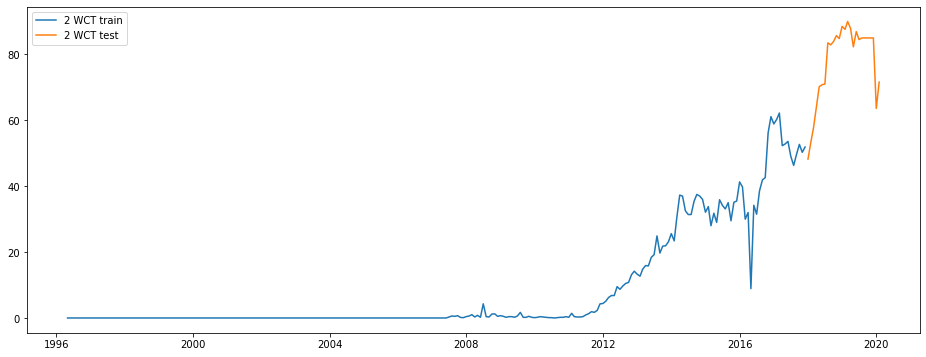

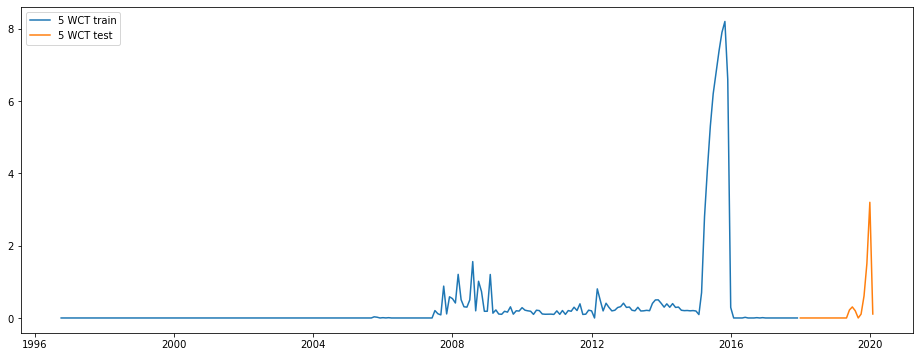

In [52]:
# отобразим разделение на трейн и тест по каждой скважине
n_well = 2 # кол-во отображаемых скважин

for well in test['Well'].unique()[:n_well]:
    plt.plot(train['Date'][:len(train['WCT'].where(train['Well'] == well))],
             train['WCT'].where(train['Well'] == well),
             label=str(well) + ' WCT train')
    plt.plot(test['Date'][:len(test['WCT'].where(test['Well'] == well))],
             test['WCT'].where(test['Well'] == well),
             label=str(well) + ' WCT test')
    n_dates_well = test['WCT'].where(test['Well'] == well).count()
    plt.legend(loc='upper left')
    plt.show()

In [53]:
test.head(3)

,Date,Day,Well,Formation,Lift type,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3",WCT,"Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours,"liquid, m3"
260,2018-01-01,43101,2,Evlanov-Livenskian,ESP,2064.009662,1709,1921.821306,2237.0,251.0,48.216327,0.828,1.164,744.0,0.0,3985.830968
261,2018-02-01,43132,2,Evlanov-Livenskian,ESP,1696.859903,1405,1944.158076,2263.0,207.0,53.396003,0.828,1.164,664.0,8.0,3641.017979
262,2018-03-01,43160,2,Evlanov-Livenskian,ESP,1661.835749,1376,2267.182131,2639.0,202.0,57.703533,0.828,1.164,739.0,5.0,3929.017879


In [54]:
# список признаков, по которым будем учить
features = ['Day', 'Well', 'Oil production, m3', 'Oil production (actual), t',
       'Water production, m3', 'Water production, t', 'Gas production, M m3',
       'Working hours', 'Downtime hours']

In [55]:
# формируем признаки и таргеты
y_train = train['WCT']
X_train = train.drop(['Date', 'WCT', 'Formation', 'Lift type'], axis=1)
X_train.head(3)

,Day,Well,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3","Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours,"liquid, m3"
0,35186,2,1549.516908,1283,0.0,0.0,173.20,0.828,1.164,336.0,408.0,1549.516908
1,35217,2,4330.917874,3586,0.0,0.0,484.11,0.828,1.164,696.0,24.0,4330.917874
2,35247,2,5179.951691,4289,0.0,0.0,630.50,0.828,1.164,744.0,0.0,5179.951691


In [56]:
y_test = test['WCT']
X_test = test.drop(['Date', 'WCT', 'Formation', 'Lift type'], axis=1)
X_test.head(3)

,Day,Well,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3","Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours,"liquid, m3"
260,43101,2,2064.009662,1709,1921.821306,2237.0,251.0,0.828,1.164,744.0,0.0,3985.830968
261,43132,2,1696.859903,1405,1944.158076,2263.0,207.0,0.828,1.164,664.0,8.0,3641.017979
262,43160,2,1661.835749,1376,2267.182131,2639.0,202.0,0.828,1.164,739.0,5.0,3929.017879


In [57]:
scaler = StandardScaler()

X_train = X_train.copy()
X_test = X_test.copy()

X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

X_train.head(3)

,Day,Well,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3","Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours,"liquid, m3"
0,-2.434624,-0.720064,-0.371670,-0.378640,-0.460229,-0.459091,-0.506767,0.828,1.164,-0.994640,4.097169,1549.516908
1,-2.420011,-0.720064,0.758126,0.749293,-0.460229,-0.459091,0.308640,0.828,1.164,0.356325,0.021877,4330.917874
2,-2.405871,-0.720064,1.103001,1.093599,-0.460229,-0.459091,0.692570,0.828,1.164,0.536454,-0.232828,5179.951691


In [58]:
# длина истории
x_len = 7

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 64
epochs = 100
bias = 1

In [59]:
train_size = len(y_train)

start = x_len + future
end = start + train_size

print(start, end)

#X_train = X_train[features].values
#y_train = y_train.iloc[start:end][target].values


x_end = len(y_test) - x_len - future
label_start = len(y_train) + bias + x_len + future
print(x_end, label_start)

#X_val = y_test.iloc[:x_end][features].values
#y_val = data.iloc[label_start:][target].values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

8 4711
954 4712


((4703, 12), (4703,), (962, 12), (962,))

In [60]:
# препроцессинг keras для временных рядов

dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [61]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (64, 7, 12)
tf.Tensor(
[[-2.42001147e+00 -7.20064016e-01  7.58126086e-01  7.49292795e-01
  -4.60229018e-01 -4.59090612e-01  3.08640168e-01  8.28000000e-01
   1.16400000e+00  3.56325258e-01  2.18772713e-02  4.33091787e+03]
 [-2.40587057e+00 -7.20064016e-01  1.10300097e+00  1.09359895e+00
  -4.60229018e-01 -4.59090612e-01  6.92569517e-01  8.28000000e-01
   1.16400000e+00  5.36453930e-01 -2.32828466e-01  5.17995169e+03]
 [-2.39125830e+00 -7.20064016e-01  1.05296222e+00  1.04364272e+00
  -4.60229018e-01 -4.59090612e-01  6.51918483e-01  8.28000000e-01
   1.16400000e+00  5.36453930e-01 -2.32828466e-01  5.05676329e+03]
 [-2.37664603e+00 -7.20064016e-01  1.11477479e+00  1.10535335e+00
  -4.60229018e-01 -4.59090612e-01  7.30597904e-01  8.28000000e-01
   1.16400000e+00  4.46389594e-01 -2.32828466e-01  5.20893720e+03]
 [-2.36250513e+00 -7.20064016e-01  1.88301670e+00  1.87232837e+00
  -4.60229018e-01 -4.59090612e-01  1.39806166e+00  8.28000000e-01
   1.16400000e+00  5.36453930e-01 -2

In [62]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)


model_3 = Sequential()

model_3.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_3.add(LSTM(32, return_sequences=True))
model_3.add(Conv1D(64, 3, activation='linear'))
model_3.add(Conv1D(64, 1, activation='linear'))
model_3.add(Flatten())
model_3.add(Dense(3, activation='linear'))
model_3.add(Dense(1, activation='linear'))

model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 7, 32)             5760      
_________________________________________________________________
lstm_3 (LSTM)                (None, 7, 32)             8320      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 64)             6208      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 64)             4160      
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 963       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [63]:
history_3 = model_3.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop]
                   )

Epoch 1/100
74/74 [==============================] - 5s 22ms/step - loss: 521.1296 - mae: 12.2998 - val_loss: 1161.2899 - val_mae: 28.4067
Epoch 2/100
74/74 [==============================] - 1s 8ms/step - loss: 632.3552 - mae: 18.7617 - val_loss: 1037.9674 - val_mae: 27.6432
Epoch 3/100
74/74 [==============================] - 1s 8ms/step - loss: 695.2617 - mae: 19.8240 - val_loss: 1038.5803 - val_mae: 27.6031
Epoch 4/100
74/74 [==============================] - 1s 8ms/step - loss: 689.9294 - mae: 20.0149 - val_loss: 1055.3516 - val_mae: 27.6462
Epoch 5/100
74/74 [==============================] - 1s 8ms/step - loss: 679.9178 - mae: 20.4671 - val_loss: 1060.4106 - val_mae: 27.6749
Epoch 6/100
74/74 [==============================] - 1s 9ms/step - loss: 675.1836 - mae: 20.6767 - val_loss: 1067.3591 - val_mae: 27.6753
Epoch 7/100
74/74 [==============================] - 1s 8ms/step - loss: 668.0108 - mae: 20.7843 - val_loss: 1078.0845 - val_mae: 27.6215
Epoch 8/100
74/74 [==============

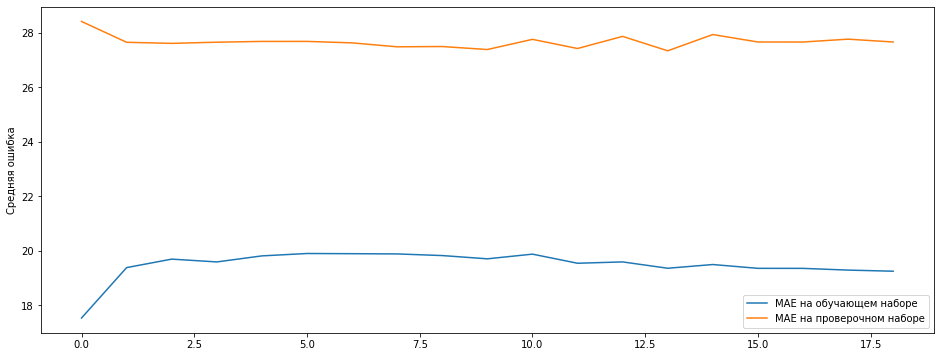

In [64]:
plt.plot(history_3.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_3.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [65]:
pred_3 = model_3.predict(dataset_train).flatten()
pred_val_3 = model_3.predict(dataset_val).flatten()

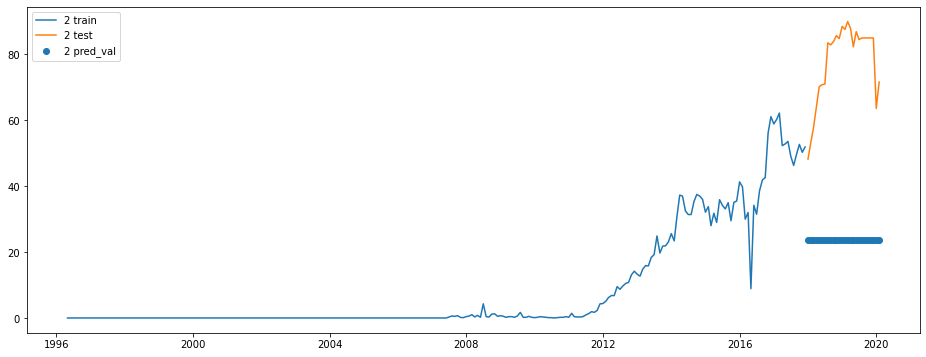

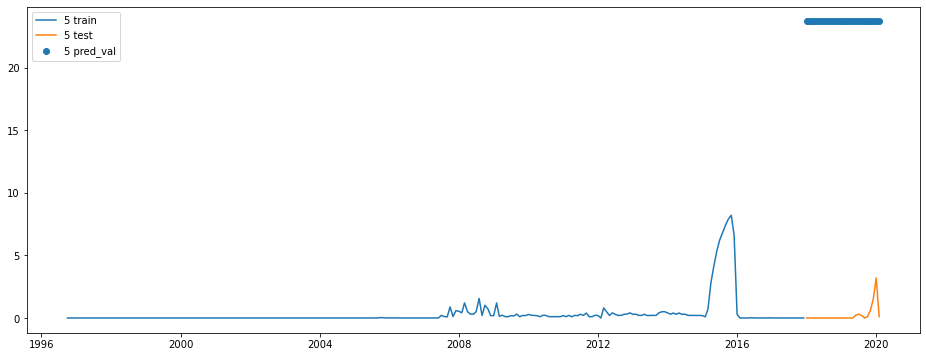

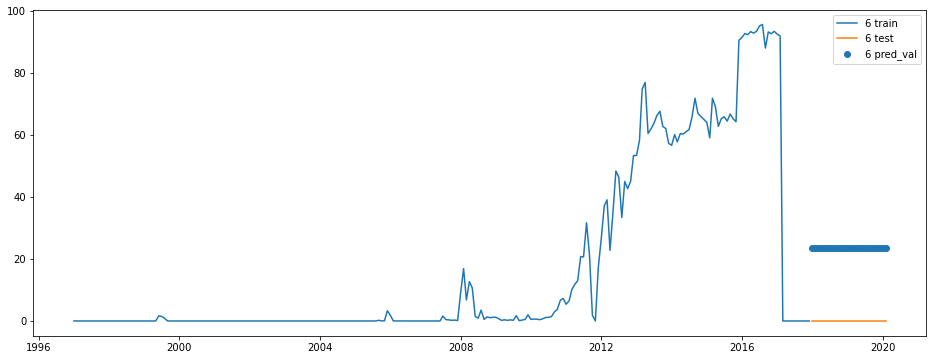

In [66]:
# отобразим графики предсказаний для первых 3-х скважин
for well in test['Well'].unique()[:3]:
    plt.plot(train['Date'][:len(train['WCT'].where(train['Well'] == well))],
             train['WCT'].where(train['Well'] == well),
             label=str(well) + ' train')
    plt.plot(test['Date'][:len(test['WCT'].where(test['Well'] == well))],
             test['WCT'].where(test['Well'] == well),
             label=str(well) + ' test')
    n_dates_well = test['WCT'].where(test['Well'] == well).count()
    plt.scatter(test['Date'][:n_dates_well], 
                pred_val_3[:n_dates_well], 
                label=str(well) + ' pred_val')
    plt.legend()
    plt.show()

**Вывод**: по каждой скважине предсказания на тестовой выборке получаются в виде прямой линии, что выглядит очень странно.

In [67]:
pred_3[:100]

array([23.687304, 23.687304, 23.687304, 23.687304, 23.687304, 23.687304,
       23.687304, 23.687304, 23.687304, 23.687304, 23.687304, 23.687304,
       23.687304, 23.687304, 23.687304, 23.687304, 23.687304, 23.687304,
       23.687304, 23.687304, 23.687304, 23.687304, 23.687304, 23.687304,
       23.687304, 23.687304, 23.687304, 23.687304, 23.687304, 23.687304,
       23.687304, 23.687304, 23.687304, 23.687304, 23.687304, 23.687304,
       23.687304, 23.687304, 23.687304, 23.687304, 23.687304, 23.687304,
       23.687304, 23.687304, 23.687304, 23.687304, 23.687304, 23.687304,
       23.687304, 23.687304, 23.687304, 23.687304, 23.687304, 23.687304,
       23.687304, 23.687304, 23.687304, 23.687304, 23.687304, 23.687304,
       23.687304, 23.687304, 23.687304, 23.687304, 23.687304, 23.687304,
       23.687304, 23.687304, 23.687304, 23.687304, 23.687304, 23.687304,
       23.687304, 23.687304, 23.687304, 23.687304, 23.687304, 23.687304,
       23.687304, 23.687304, 23.687304, 23.687304, 

In [68]:
pred_val_3[:100]

array([23.687304 , 23.687304 , 23.687304 , 23.687304 , 23.687304 ,
       23.687304 , 23.687304 , 23.687304 , 23.687304 , 23.687304 ,
       23.687304 , 23.687304 , 23.687304 , 23.687304 , 23.687304 ,
       23.687304 , 23.687304 , 23.687304 , 23.687304 , 23.687304 ,
       23.687304 , 23.687304 , 23.687304 , 23.687304 , 23.687304 ,
       23.687304 , 23.687304 , 23.687304 , 23.687304 , 23.687304 ,
       23.687304 , 23.687304 , 23.687304 , 23.687304 , 23.687304 ,
       23.687304 , 23.687304 , 23.687304 , 23.687304 , 23.687304 ,
       23.687304 , 23.687304 , 23.687304 , 23.687304 , 23.687304 ,
       23.687304 , 35.87283  , 53.825394 , 70.27328  , 76.16828  ,
       70.247986 , 59.42507  , -3.287507 , -3.6945503, -3.6972399,
       -4.2190723, -2.5497782, -1.0013969, -3.2697008, -4.3012385,
       -5.0401883, -4.5451794, -3.0716317, -5.0477133, -4.4689217,
       -4.831533 , -4.372402 , -3.743474 , -3.4870868, -3.7822537,
       -4.791066 , -5.616806 , -4.1675596, -3.5036957, -3.0967

In [69]:
# Вариант: Разбиваем на трейн и тест для одной скважины (скв.2, диапазон [260:285])

# train = df.drop(df.index[260:286])
# test = df.iloc[260:286, :]
# print('Train Dataset:',train.shape)
# print('Test Dataset:',test.shape)